In [ ]:
pip install tensorflow==2.5.0

  Using cached tensorflow-2.5.0-cp39-cp39-win_amd64.whl (422.6 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached h5py-3.1.0-cp39-cp39-win_amd64.whl (2.7 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached grpcio-1.34.1-cp39-cp39-win_amd64.whl (2.9 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached google_auth-2.14.0-py2.py3-none-any.whl (175 kB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5p

In [ ]:
pip install opencv-python

     ---------------------------------------- 35.6/35.6 MB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# needed to import dataset from google drive into colab 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# copy RAVDESS dataset from gdrive and unzip
!cp '/content/gdrive/My Drive/original_dataset.zip' .
!unzip -q original_dataset.zip 


In [3]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [5]:
#import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\Users\syed\Documents\projects\door switch road\original_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7535 files belonging to 4 classes.


In [6]:

class_names = dataset.class_names
class_names

['Switch', 'door', 'road', 'stairs']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 2 0 3 0 3 2 1 3 3 3 1 0 2 0 0 2 0 1 1 0 0 3 3 1 1 3 3 0 3 3 3]


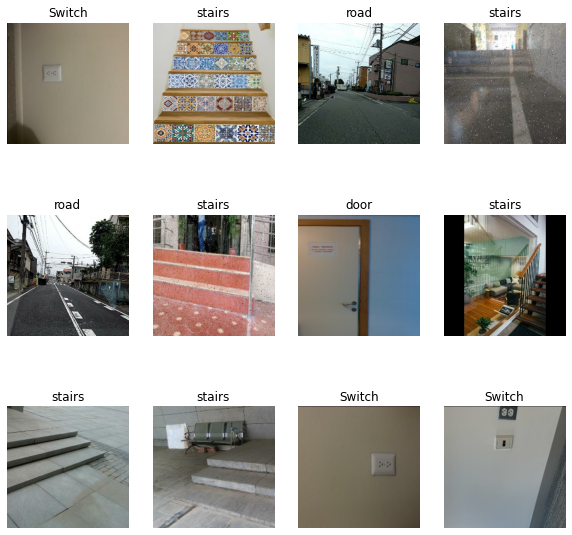

In [8]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
#Function to Split Dataset
len(dataset)

236

In [10]:
train_size = 0.8
len(dataset)*train_size

188.8

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

182

In [13]:
val_size=0.1
len(dataset)*val_size

23.6

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

176

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

188

In [19]:
len(val_ds)

23

In [20]:
len(test_ds)

25

In [21]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
#Building the Model
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./244),
])

In [23]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 224, 224, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 222, 222, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 111, 111, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 109, 109, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 54, 54, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 52, 52, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 26, 26, 64)         

In [26]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
188/188 [==============================] - 91s 341ms/step - loss: 1.0595 - accuracy: 0.5623 - val_loss: 0.6898 - val_accuracy: 0.7283
Epoch 2/100
188/188 [==============================] - 43s 229ms/step - loss: 0.6296 - accuracy: 0.7623 - val_loss: 0.3656 - val_accuracy: 0.8668
Epoch 3/100
188/188 [==============================] - 44s 234ms/step - loss: 0.4466 - accuracy: 0.8295 - val_loss: 0.3321 - val_accuracy: 0.8641
Epoch 4/100
188/188 [==============================] - 43s 231ms/step - loss: 0.4015 - accuracy: 0.8533 - val_loss: 0.3270 - val_accuracy: 0.8736
Epoch 5/100
188/188 [==============================] - 43s 230ms/step - loss: 0.3494 - accuracy: 0.8716 - val_loss: 0.2580 - val_accuracy: 0.9130
Epoch 6/100
188/188 [==============================] - 44s 234ms/step - loss: 0.2952 - accuracy: 0.8918 - val_loss: 0.2001 - val_accuracy: 0.9266
Epoch 7/100
188/188 [==============================] - 43s 230ms/step - loss: 0.2819 - accuracy: 0.8971 - val_loss: 0.1840 -

In [28]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 21s 28ms/step - loss: 0.1084 - accuracy: 0.9725


In [29]:
#You can see above that we get 97.00% accuracy for our test dataset. This is considered to be a pretty good accuracy
scores
#Score is just a list containing loss and accuracy value

[0.10841865837574005, 0.9725000262260437]

In [30]:
#Plotting the Accuracy and Loss Curves
history

In [31]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 188}

In [32]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

100

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0594717264175415,
 0.629604697227478,
 0.4465586841106415,
 0.4014910161495209,
 0.3494126498699188]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: stairs
1/1 [==============================] - 0s 216ms/step
predicted label: stairs


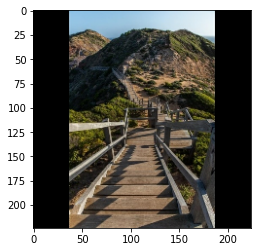

In [39]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


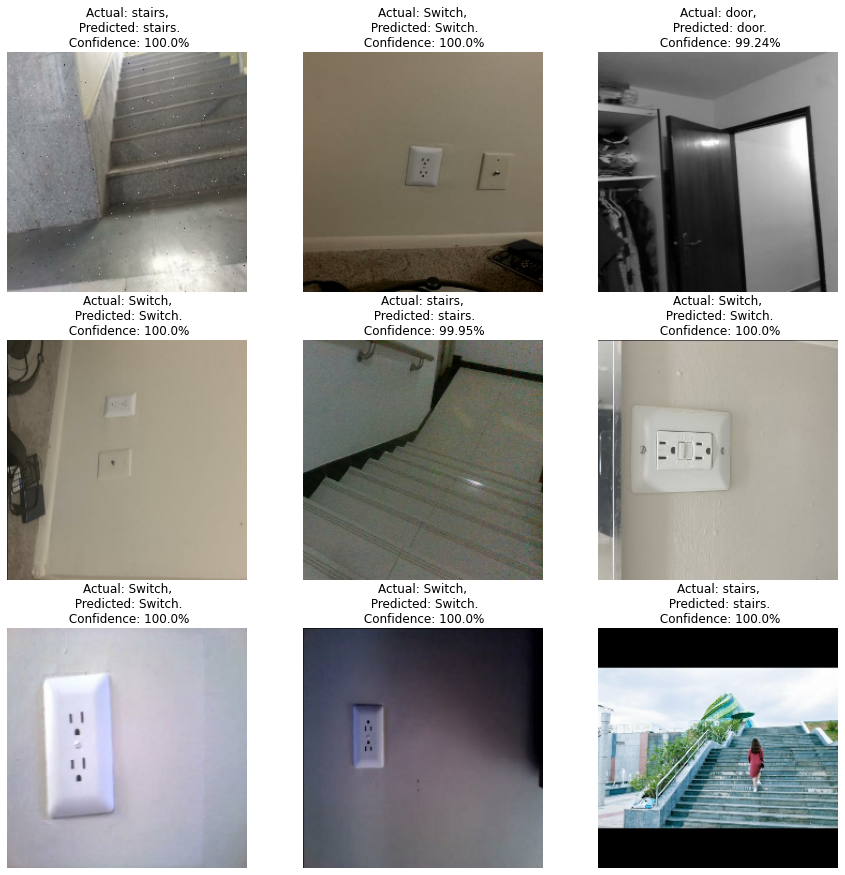

In [41]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
#Saving the Model
model.save("9skfdkf.h5")

In [46]:
#Saving the Model
model.save("97accur.pb")